# -*- UTF-8 -*-
# !/usr/bin/env python3
# by zhiyuan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
egwas_threshold = 0.05/3333393

In [103]:
egwas_threshold

1.4999731504806066e-08

## cis-eQTL

In [15]:
def each_gene_cis(cis_file,threshold,group):
    gene2snp = {}
    f1 = open(cis_file,'r')
    for l in f1:
        if l.startswith('SNP'):
            with open(f"{group}_all_cis.txt", 'w') as f2:
                f2.write(l)
        else:
            ls = l.strip().split('\t')
            snp = ls[0]
            gene = ls[1]
            p_value = float(ls[-2])
            beta = float(ls[2])
            if p_value < threshold:
                if gene not in gene2snp:
                    gene2snp[gene] = {'snp_ls':[],'lead_snp':'','lead_snp_beta':0,'lead_snp_p':1}
                gene2snp[gene]['snp_ls'].append(snp)
                if gene2snp[gene]['lead_snp_p'] > p_value:
                    gene2snp[gene]['lead_snp'] = snp
                    gene2snp[gene]['lead_snp_beta'] = beta
                    gene2snp[gene]['lead_snp_p'] = p_value
                with open(f"{group}_all_cis.txt", 'a') as f2:
                    f2.write(l)           
    f1.close()
    with open(f"{group}_each_gene_cis.txt", 'w') as f2:
        f2.write(f"gene\tlead_snp\tlead_snp_beta\tlead_snp_p\tnum_snp\tsnp_ls\n")
    
    for gene in gene2snp:
        snp_ls = gene2snp[gene]['snp_ls']
        lead_snp = gene2snp[gene]['lead_snp']
        beta = gene2snp[gene]['lead_snp_beta']
        p = gene2snp[gene]['lead_snp_p']
        if len(snp_ls) >= 3:
            with open(f"{group}_each_gene_cis.txt", 'a') as f2:
                a = f"{gene}\t{lead_snp}\t{beta}\t{p}\t{len(snp_ls)}\t{'|'.join(snp_ls)}\n"
                f2.write(a)

In [16]:
cis = '/work/03.eQTL_analysis/01.result/cis_qqnorm_result.txt'

In [17]:
each_gene_cis(cis,egwas_threshold,'ck')

## trans-eQTL

In [3]:
ck_trans = pd.read_csv('/work/03.eQTL_analysis/02.trans_eQTL_filtering/trans_ld_final.txt',header=0,sep='\t')
ck_trans = ck_trans.loc[ck_trans['p-value']<egwas_threshold,:]
print(ck_trans.shape)
ck_trans.head()

(16333, 10)


,SNP,gene,beta,t-stat,p-value,FDR,chr,pos,bin,cluster
0,rs1_177295,LOC_Os01g01010,0.288394,7.533080,1.334233e-13,1.281615e-09,1,177295,bin1,LOC_Os01g01010_1
1,rs8_5218412,LOC_Os01g01060,-0.132073,-6.568851,9.100705e-11,4.937431e-07,8,5218412,bin7,LOC_Os01g01060_1
2,rs8_18806979,LOC_Os01g01060,-0.131498,-6.479385,1.604083e-10,8.205569e-07,8,18806979,bin8,LOC_Os01g01060_2
3,rs1_807775,LOC_Os01g01120,-0.144215,-6.524321,1.207683e-10,6.364307e-07,1,807775,bin2,LOC_Os01g01120_1
4,rs3_3325859,LOC_Os01g01120,0.138455,6.234652,7.306775e-10,3.161523e-06,3,3325859,bin39,LOC_Os01g01120_2


In [5]:
ck_trans_result = ck_trans.groupby('gene').size().reset_index(name='eqtl_num')
ck_trans_result.head()

,gene,eqtl_num
0,LOC_Os01g01010,1
1,LOC_Os01g01060,2
2,LOC_Os01g01120,4
3,LOC_Os01g01280,1
4,LOC_Os01g01290,2


### Genome distribution of eQTLs (x-axis) and the target genes (y-axis)

In [25]:
ck_cis = pd.read_csv('/work/03.eQTL_analysis/01.result/ck_each_gene_cis.txt', sep='\t')
ck_cis = ck_cis.iloc[:,:-2]
print('ck_cis',ck_cis.shape)

ck_cis (7367, 4)
sa_cis (7796, 4)


In [27]:
ck_trans = ck_trans.loc[:,['gene','SNP','beta','p-value']]
ck_trans.columns = ck_cis.columns

In [28]:
gene_pos = pd.read_csv("/work/data/gene_loc.txt",header=0,sep='\t')
gene_pos = gene_pos.drop_duplicates(subset=['geneid'])
gene_pos['gene_pos'] = (gene_pos['s1'].astype(int) + gene_pos['s2'].astype(int))/2
gene_pos.sort_values(by=['chr','gene_pos'],inplace=True)
gene_pos.rename(columns={'chr':'gene_chr'},inplace=True)

In [30]:
ck_cis['type'] = 'cis'
ck_trans['type'] = 'trans'
ck_fin = pd.concat([ck_cis, ck_trans], axis=0)
ck_fin['snp_chr'] = ck_fin['lead_snp'].apply(lambda x: int(x.split('_')[0][2:]))
ck_fin['snp_pos'] = ck_fin['lead_snp'].apply(lambda x: int(x.split('_')[1]))
ck_fin['-log10(p)'] = -np.log10(ck_fin['lead_snp_p'])
ck_fin = pd.merge(ck_fin,gene_pos,left_on='gene',right_on='geneid',how='left')
ck_fin = ck_fin.loc[:,['gene','gene_chr','gene_pos','lead_snp','snp_chr', 'snp_pos', '-log10(p)','type','lead_snp_beta','lead_snp_p']]
ck_chr_length = pd.DataFrame(ck_fin.groupby('snp_chr')['snp_pos'].max())
ck_chr_length.columns = ['chr_length']
ck_fin = pd.merge(ck_fin,ck_chr_length,left_on='snp_chr',right_index=True,how='left')
ck_fin.rename(columns={'chr_length':'snp_chr_length'},inplace=True)
ck_fin = pd.merge(ck_fin,ck_chr_length,left_on='gene_chr',right_index=True,how='left')
ck_fin.rename(columns={'chr_length':'gene_chr_length'},inplace=True)
ck_fin['gene_plot'] = ck_fin['gene_chr'] + (ck_fin['gene_pos']/ck_fin['gene_chr_length'])-0.5
ck_fin['snp_plot'] = ck_fin['snp_chr'] + (ck_fin['snp_pos']/ck_fin['snp_chr_length']) -0.5

In [31]:
ck_fin = ck_fin.sort_values(by=['type','-log10(p)'],ascending=[False,True])
ck_fin.head()

,gene,gene_chr,gene_pos,lead_snp,snp_chr,snp_pos,-log10(p),type,lead_snp_beta,lead_snp_p,snp_chr_length,gene_chr_length,gene_plot,snp_plot
17987,LOC_Os08g01940,8,583330.0,rs1_30061496,1,30061496,7.856983,trans,0.383071,1.390008e-08,43243424,28438543,7.520512,1.195169
10603,LOC_Os02g38820,2,23467020.0,rs1_3450148,1,3450148,7.861278,trans,-0.211625,1.376328e-08,43243424,35933687,2.153065,0.579784
12459,LOC_Os03g55990,3,31870334.0,rs10_22051225,10,22051225,7.872172,trans,-0.204680,1.342232e-08,23204854,36412946,3.375247,10.450285
7817,LOC_Os01g07590,1,3647974.5,rs9_6587443,9,6587443,7.899743,trans,-0.167190,1.259671e-08,22931604,43243424,0.584359,8.787265
8169,LOC_Os01g21880,1,12280336.0,rs3_2118130,3,2118130,7.904325,trans,-0.489705,1.246451e-08,36412946,43243424,0.783982,2.558170


In [32]:
from matplotlib.colors import Normalize

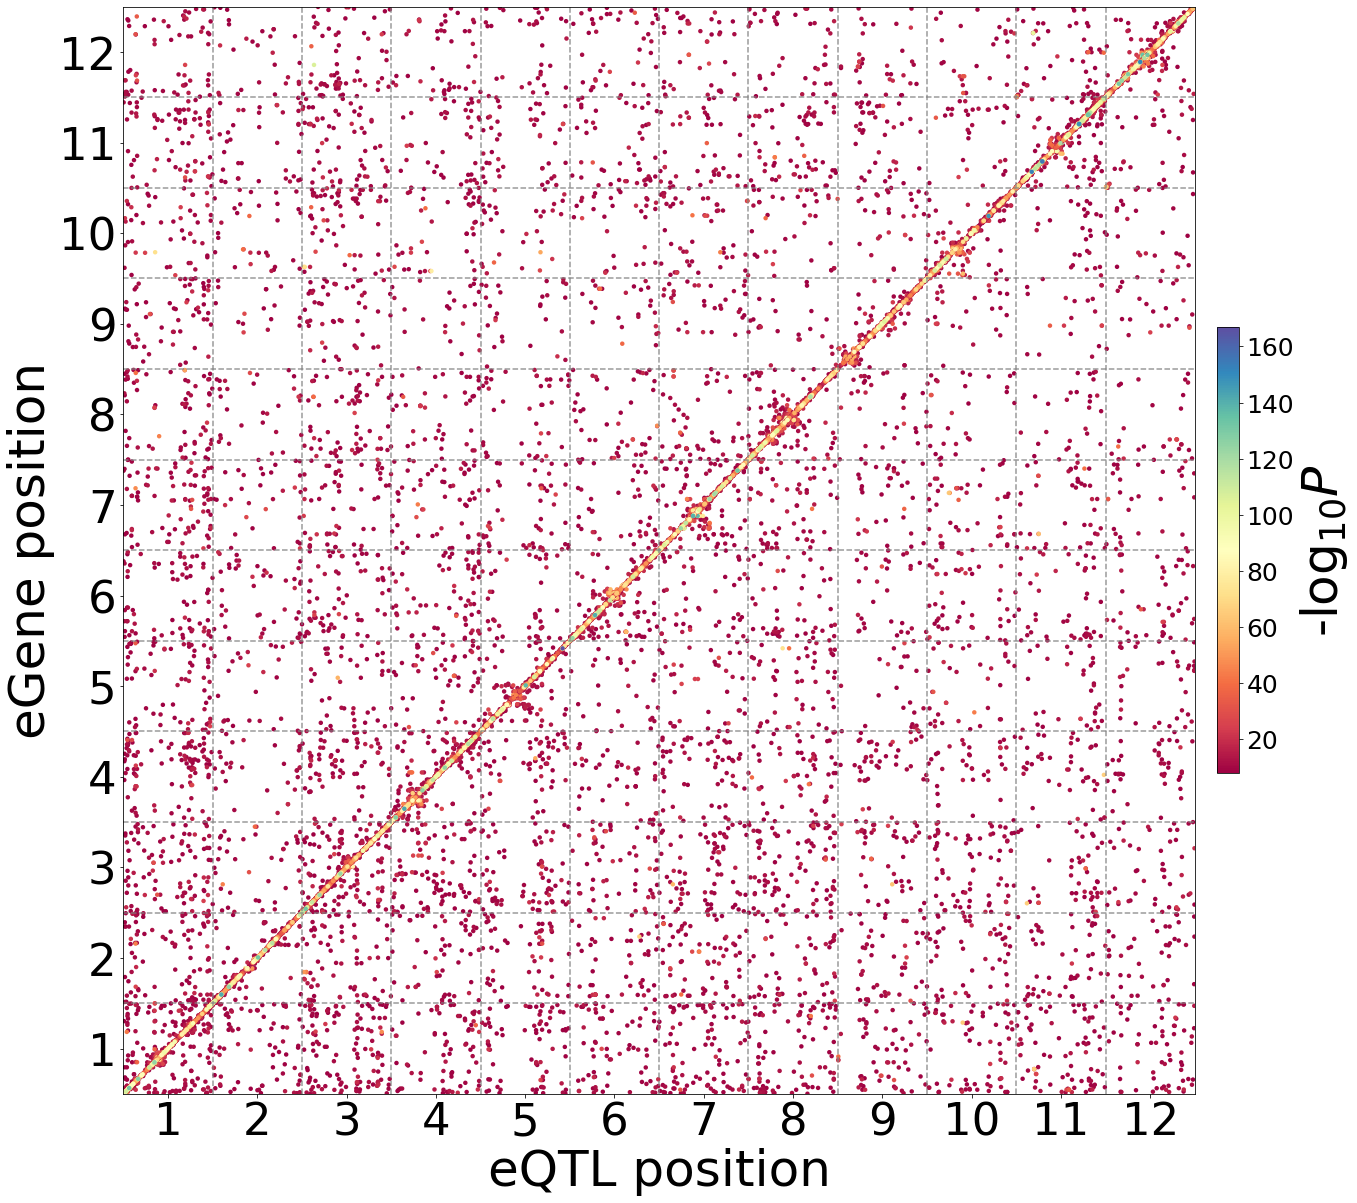

In [34]:
# 绘制散点图，x轴为gene_plot，y轴为snp_plot
fig, ax = plt.subplots(figsize=(20,20))
cmap = plt.get_cmap('Spectral',256)
norm = Normalize(vmin=min(ck_fin['-log10(p)']), vmax=max(ck_fin['-log10(p)']))
sns.scatterplot(x="snp_plot", y="gene_plot", data=ck_fin, s=20, alpha=1, color=[cmap(norm(p)) for p in ck_fin['-log10(p)']], edgecolor='none')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 避免自动颜色条
cbar = fig.colorbar(sm, ax=ax, pad=0.02, fraction=0.02, orientation='vertical',aspect=20)
cbar.set_label(r'-log$_{10} P$',fontsize=50)
cbar.ax.tick_params(labelsize=25)
plt.ylabel('eGene position',fontsize=50)
plt.xlabel('eQTL position',fontsize=50)
plt.xticks([x for x in range(1,13)],fontsize=45)
plt.yticks([x for x in range(1,13)],fontsize=45)
plt.xlim(0.5,12.5)
plt.ylim(0.5,12.5)
for i in range(1,12):
    plt.plot([i+0.5,i+0.5],[0.5,12.5],'--',color='gray',alpha=0.8)
for i in range(1,12):
    plt.plot([0.5,12.5],[i+0.5,i+0.5],'--',color='gray',alpha=0.8)
plt.savefig('ck_trans_eqtl_cis.pdf',bbox_inches='tight')
plt.show()

In [41]:
freq = pd.read_csv("/work/data/freq.txt",sep='\t',header=0)
freq.head()

,chr,snp,a1_freq,a2_freq,lead_snp
0,1,1178,0.911622,0.088378,rs1_1178
1,1,1203,0.716707,0.283293,rs1_1203
2,1,1249,0.735472,0.264528,rs1_1249
3,1,1266,0.810533,0.189467,rs1_1266
4,1,1277,0.737288,0.262712,rs1_1277


In [43]:
ck_fin = pd.merge(ck_fin,freq.loc[:,['lead_snp','a2_freq']],on='lead_snp',how='left')
ck_fin.rename(columns={'a2_freq':'af'},inplace=True)
ck_fin.head()

,gene,gene_chr,gene_pos,lead_snp,snp_chr,snp_pos,-log10(p),type,lead_snp_beta,lead_snp_p,snp_chr_length,gene_chr_length,gene_plot,snp_plot,af
0,LOC_Os08g01940,8,583330.0,rs1_30061496,1,30061496,7.856983,trans,0.383071,1.390008e-08,43243424,28438543,7.520512,1.195169,0.079298
1,LOC_Os02g38820,2,23467020.0,rs1_3450148,1,3450148,7.861278,trans,-0.211625,1.376328e-08,43243424,35933687,2.153065,0.579784,0.177361
2,LOC_Os03g55990,3,31870334.0,rs10_22051225,10,22051225,7.872172,trans,-0.204680,1.342232e-08,23204854,36412946,3.375247,10.450285,0.254843
3,LOC_Os01g07590,1,3647974.5,rs9_6587443,9,6587443,7.899743,trans,-0.167190,1.259671e-08,22931604,43243424,0.584359,8.787265,0.412833
4,LOC_Os01g21880,1,12280336.0,rs3_2118130,3,2118130,7.904325,trans,-0.489705,1.246451e-08,36412946,43243424,0.783982,2.558170,0.055085


### PVE plot

In [47]:
ck_eqtl_result = pd.read_csv('./pve_fin.txt',header=0,sep='\t')

In [48]:
ck_eqtl_result.groupby('type').median()

,gene_chr,gene_pos,snp_chr,snp_pos,X.log10.p.,lead_snp_beta,lead_snp_p,snp_chr_length,gene_chr_length,gene_plot,snp_plot,af,se,pve
type,,,,,,,,,,,,,,
cis,6,16694213.0,6,16697979,19.272164,0.262485,5.343627e-20,31214051,31214051,5.572369,5.571928,0.259080,0.042528,0.092156
trans,6,16036817.0,6,15962195,12.186826,0.255385,6.503896e-13,29668517,31214051,5.620491,5.786726,0.162833,0.050673,0.058892


In [51]:
from matplotlib.font_manager import FontProperties

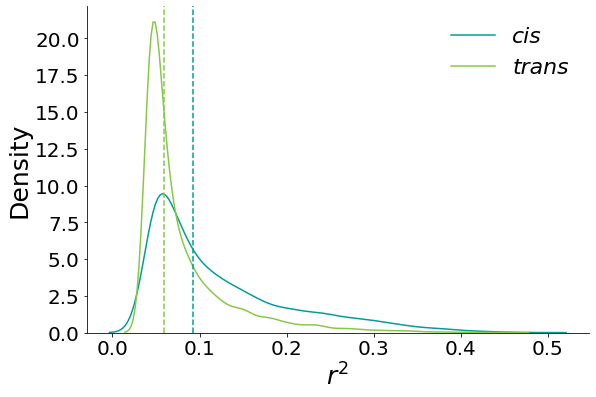

In [52]:
ck_all = ck_eqtl_result.copy()
plt.figure(figsize=(9, 6))
# sns.set_style('white')
sns.kdeplot(ck_all[ck_all['type']=='cis']['pve'], color='#019d96', label='cis',fill=False)
sns.kdeplot(ck_all[ck_all['type']=='trans']['pve'], color='#87c847', label='trans',fill=False)
# 添加x=ck_all[ck_all['type']=='cis']['pve'].median()
plt.axvline(x=ck_all[ck_all['type']=='cis']['pve'].median(), color='#019d96', linestyle='--')
plt.axvline(x=ck_all[ck_all['type']=='trans']['pve'].median(), color='#87c847', linestyle='--')
plt.xlabel(r'$r^2$', fontsize=25)
plt.ylabel('Density', fontsize=25)
sns.despine(left=False, bottom=False)
font = FontProperties()
font.set_style('italic')
# font.set_weight('bold')
font.set_size(22)
plt.legend(prop=font,frameon=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./ck_pve.pdf', dpi=300, bbox_inches='tight')
plt.show()